<a href="https://colab.research.google.com/github/manuelapop/demo_dataset/blob/main/Copy_of_datasettemplates_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        76
           1       0.79      1.00      0.88        11
           2       0.75      0.67      0.71         9
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00         1

    accuracy                           0.92       100
   macro avg       0.70      0.73      0.71       100
weighted avg       0.89      0.92      0.91       100

Confusion Matrix:
 [[74  0  2  0  0]
 [ 0 11  0  0  0]
 [ 3  0  6  0  0]
 [ 0  3  0  0  0]
 [ 0  0  0  0  1]]


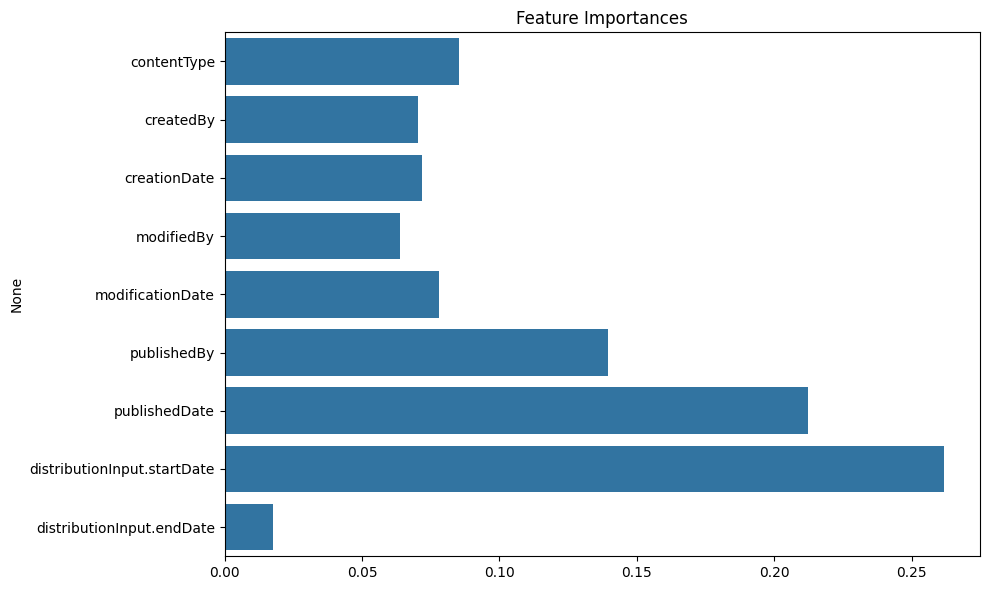

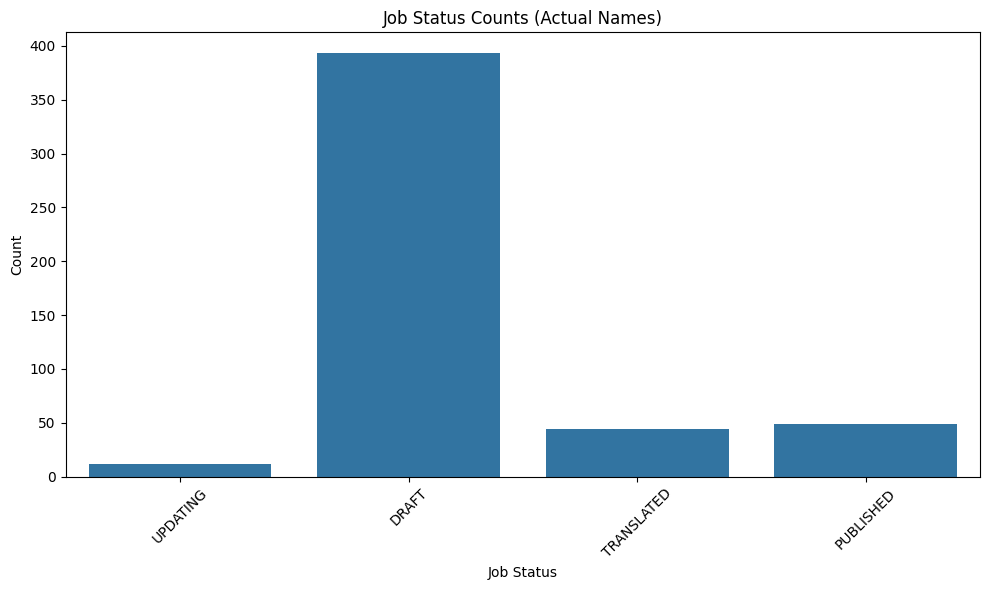

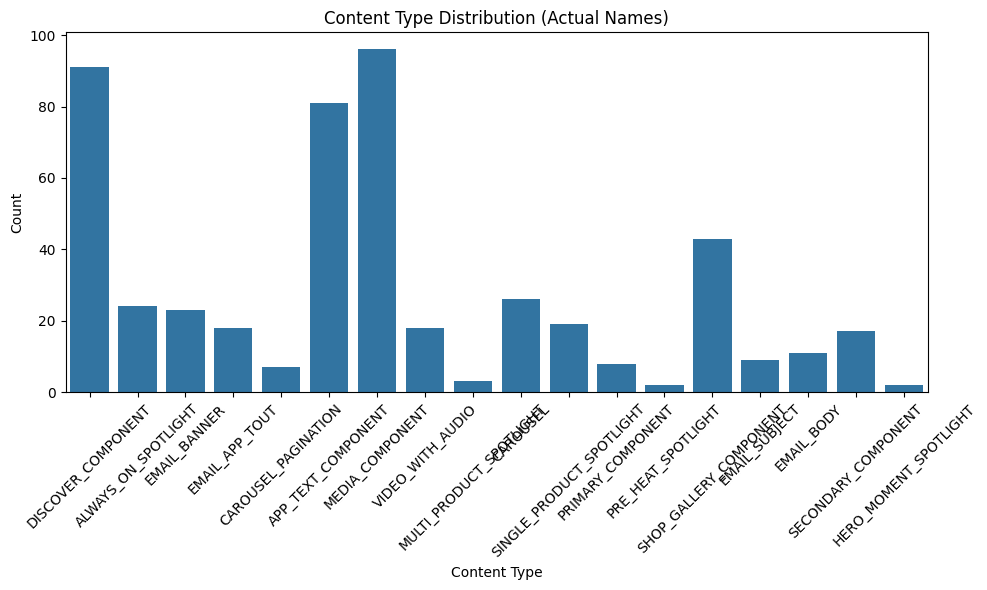

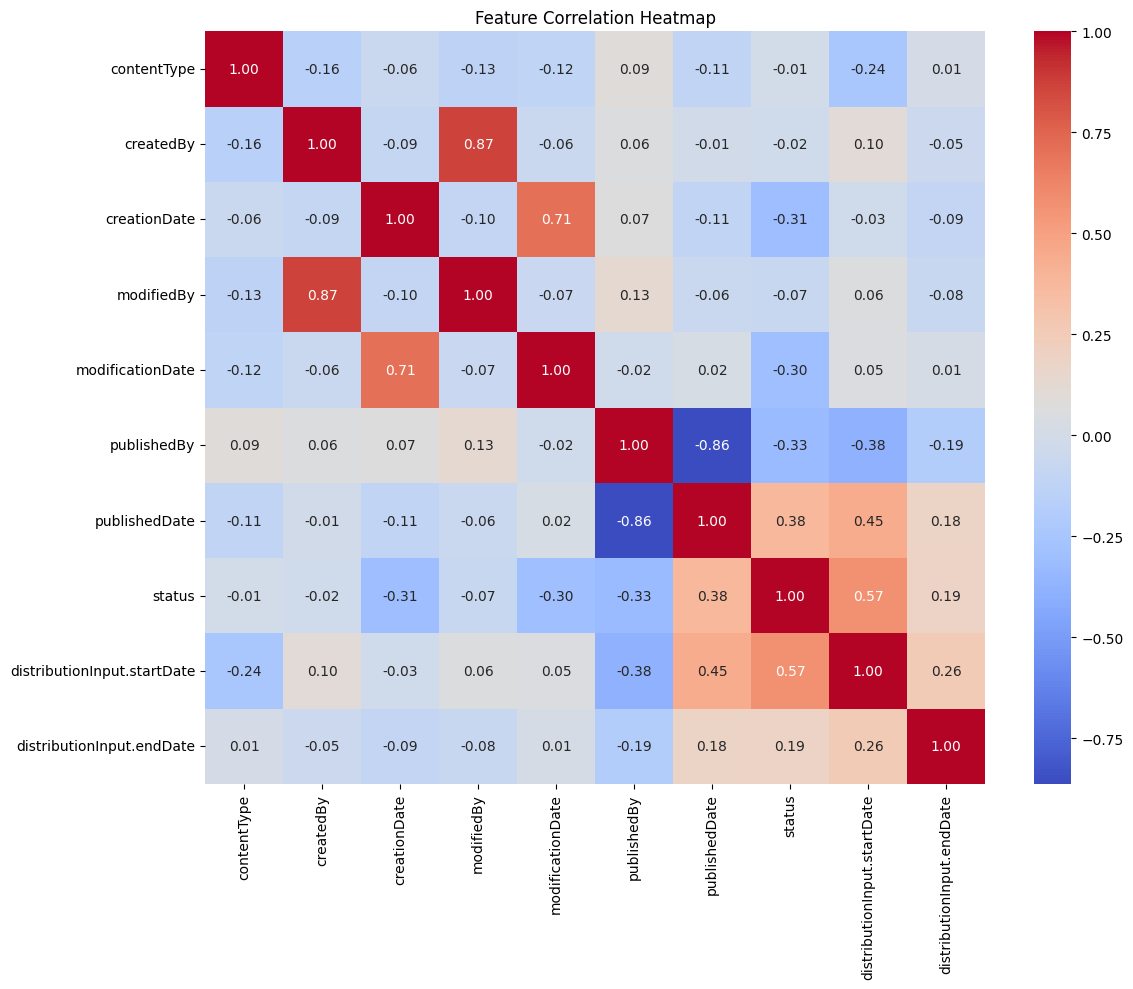

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load and Parse JSON ---
with open("TemplateTargetingJobs.json", "r") as file:
    data = json.load(file)

jobs = data['data']['templateTargetingJobs']['jobs']
df = pd.json_normalize(jobs)

# --- 2. Save original status and contentType for plotting ---
df['status_name'] = df['status']
df['contentType_name'] = df['contentType']

# --- 3. Encode Categorical Features for Modeling ---
label_encoders = {}
for column in ['contentType', 'createdBy', 'modifiedBy', 'publishedBy', 'status']:
    le = LabelEncoder()
    df[column] = df[column].fillna("Unknown")
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# --- 4. Convert Dates to Numeric ---
for column in ['creationDate', 'modificationDate', 'publishedDate', 'distributionInput.startDate', 'distributionInput.endDate']:
    df[column] = pd.to_datetime(df[column], errors='coerce')
    df[column] = df[column].astype('int64') // 10**9  # seconds since epoch

# --- 5. Drop Rows with Missing Target ---
df = df.dropna(subset=['status'])

# --- 6. Save Cleaned Dataset ---
df.to_csv("job_dataset.csv", index=False)

# --- 7. Prepare Features and Target ---
X = df.drop(columns=['id', 'name', 'status', 'status_name', 'contentType_name'])
y = df['status']

# --- 8. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 9. Train Model ---
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# --- 10. Evaluate Model ---
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- 11. Feature Importance ---
importances = model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances")
plt.tight_layout()
plt.savefig("feature_importances.png")
plt.show()

# --- 12. Static Visualizations with Actual Names ---
# Status Counts
plt.figure(figsize=(10, 6))
sns.countplot(x='status_name', data=df)
plt.title("Job Status Counts (Actual Names)")
plt.xlabel("Job Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("job_status_counts_actual.png")
plt.show()

# Content Type Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='contentType_name', data=df)
plt.title("Content Type Distribution (Actual Names)")
plt.xlabel("Content Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("content_type_distribution_actual.png")
plt.show()

# Correlation Heatmap (drop string columns)
corr_df = df.drop(columns=['id', 'name', 'status_name', 'contentType_name'])
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

# --- 13. Interactive Plots with Plotly ---
# Interactive bar plot for job status counts
status_counts = df['status_name'].value_counts().reset_index()
status_counts.columns = ['Job Status', 'Count']
fig_status = px.bar(
    status_counts,
    x='Job Status', y='Count',
    labels={'Job Status': 'Job Status', 'Count': 'Count'},
    title='Job Status Counts (Interactive)'
)
fig_status.show()

# Interactive bar plot for content type counts
content_counts = df['contentType_name'].value_counts().reset_index()
content_counts.columns = ['Content Type', 'Count']
fig_content = px.bar(
    content_counts,
    x='Content Type', y='Count',
    labels={'Content Type': 'Content Type', 'Count': 'Count'},
    title='Content Type Distribution (Interactive)'
)
fig_content.show()

# Interactive grouped bar plot (status by content type)
fig_grouped = px.histogram(
    df, x='contentType_name', color='status_name',
    barmode='group',
    title='Content Type by Job Status (Interactive)',
    labels={'contentType_name': 'Content Type', 'status_name': 'Job Status'}
)
fig_grouped.show()